# Data Loading Issues with Python

This notebook demonstrates data cleaning principles in Python. First we take a look at some encoding issues using a contrived example, and then we work through an example of loading some data as published on the Open Data portal. Note that this example is constructed with Python 3, which uses UTF8 encodings by default as a major difference from Python 2. There is also a similar notebook focused on R.

- [Part 1: Encoding Issues](#Encoding-Issues)
- [Part 2: Example: Open Data](#Example:-Open-Data)

In [1]:
%matplotlib inline

import requests
import os
import urllib.parse
import re

import pandas as pd     
import numpy as np

# Encoding Issues
Computers ultimately represent everything as a number, and over time, different operating systems, and different languages there have been many ways of representing text. Most encodings (except for ones designed specifically for Asian languages) are extensions of ASCII, which was designed for English, so the English alphabet and most common punctuation characters are usually not a problem, but ASCII does not include things like accented characters for French.

To demonstrate some of the potential issues, I made a file in Notepad and saved it using the default ANSI encoding (this default is changing to UTF8 as of the May 2019 update of Windows 10). This shows French text with accents, and non-ASCII punctuation characters. This formatting is similar to Excel's settings when used in French to generate a CSV file - it uses a ; instead of , for the delimiter as , is the decimal separator.

```
DEPARTEMENT;DÉPENSES;Punctuation
Administration du pipe-line du Nord;123456,88;“–”
Agence canadienne d’évaluation environnementale;999999,24;†•
Agence de développement économique du Canada pour les régions du Québec;234567,00;€
```

## Issue 1: Can't read the file at all with UnicodeDecodeError


In [2]:
# This will produce the error "UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc9 in position 1: invalid continuation byte"
try:
    pd.read_csv('data/NotepadFrench.csv')
except UnicodeDecodeError as error:
    print(error)    

'utf-8' codec can't decode byte 0xc9 in position 13: invalid continuation byte


In order to fix the UnicodeDecodeError, you need to determine the right encoding to load the file. There are many possibilities, fully documented here: https://docs.python.org/3/library/codecs.html#standard-encodings.

## Issue 2: Not all characters loaded properly - missing values and mojibake
`latin-1` (also known as `ISO-8859-1`) is a common encoding for Western European text including French, but it's not showing the advanced punctuation characters as they map to unprintable control characters (though they are there, as demonstrated by computing the length of the string). 

In [3]:
no_punctuation = pd.read_csv('data/NotepadFrench.csv', sep=";", encoding="latin-1")
no_punctuation["Punctuation Length"] = no_punctuation["Punctuation"].str.len()
no_punctuation

,DEPARTEMENT,DÉPENSES,Punctuation,Punctuation Length
0,Administration du pipe-line du Nord,"123456,88",,3
1,Agence canadienne dévaluation environnementale,"999999,24",,2
2,Agence de développement économique du Canada p...,"234567,00",,1


Another possibility is that characters map to incorrect visible characters. Here we attempt to load it using IBM863, 'MS-DOS French Canada', which was used by MS-DOS systems in Canada.

In [4]:
pd.read_csv('data/NotepadFrench.csv', sep=";", encoding="IBM863")

,DEPARTEMENT,D╔PENSES,Punctuation
0,Administration du pipe-line du Nord,"123456,88",ôûË
1,Agence canadienne dÊΘvaluation environnementale,"999999,24",¶Ï
2,Agence de dΘveloppement Θconomique du Canada p...,"234567,00",Ç


`windows-1252` is a Windows specific superset of `ISO-8859-1` which includes several additional characters. It is one of several different 'ANSI Codepages' for representing different languages. This is the most likely option if a file was created on a Windows system in English, French, or most Western European languages.

In [5]:
wrong_decimal = pd.read_csv('data/NotepadFrench.csv', sep=";", encoding="windows-1252")
wrong_decimal

,DEPARTEMENT,DÉPENSES,Punctuation
0,Administration du pipe-line du Nord,"123456,88",“–”
1,Agence canadienne d’évaluation environnementale,"999999,24",†•
2,Agence de développement économique du Canada p...,"234567,00",€


While not strictly an encoding issue, one other issue with dealing with multiple languages is different localization settings like date formats and decimal separators. `DÉPENSES` has been read in as text rather than a number as Pandas expects a . not , by default.

In [6]:
wrong_decimal["DÉPENSES"].sum()

'123456,88999999,24234567,00'

In [7]:
correct_sample = pd.read_csv('data/NotepadFrench.csv', sep=";", encoding="windows-1252", decimal=",")
correct_sample

,DEPARTEMENT,DÉPENSES,Punctuation
0,Administration du pipe-line du Nord,123456.88,“–”
1,Agence canadienne d’évaluation environnementale,999999.24,†•
2,Agence de développement économique du Canada p...,234567.00,€


In [8]:
correct_sample["DÉPENSES"].sum()

1358023.12

Here we save a version of the file which plays nicely with Pandas defaults.

In [9]:
correct_sample.to_csv('data/utf8French.csv', index=False)
pd.read_csv('data/utf8French.csv')

,DEPARTEMENT,DÉPENSES,Punctuation
0,Administration du pipe-line du Nord,123456.88,“–”
1,Agence canadienne d’évaluation environnementale,999999.24,†•
2,Agence de développement économique du Canada p...,234567.00,€


## Issue 3: Loading UTF8 into Excel

Excel defaults to the ANSI codepage used by the operating system (e.g. Windows-1252), and will not properly load UTF8 text via File->Open.

The solution is to import the text into Excel instead and choose the appropriate encoding.
![Loading UTF8 into Excel using Text Import](ExcelImport.png)

In [10]:
pd.read_csv('data/utf8French.csv', encoding="ansi")

,DEPARTEMENT,DÃ‰PENSES,Punctuation
0,Administration du pipe-line du Nord,123456.88,â€œâ€“â€
1,Agence canadienne dâ€™Ã©valuation environnemen...,999999.24,â€ â€¢
2,Agence de dÃ©veloppement Ã©conomique du Canada...,234567.00,â‚¬


# Example: Open Data
Fuel consumption ratings (NRCAN): https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64

In this scenario, I want to do some analysis on a dataset published to the open data portal. This dataset is spread over multiple files for different years, and there are some minor changes to the columns over time. Like many datasets on Open Data it has some features which make it easier for people to look at but harder for machines - the column names are formatted over two rows, and there is some extra descriptions of fields below the main data section. A bit more unusually, it also has extra blank lines between rows and for some years, there are lots of extra blank columns and rows at the end.

First I wrote some code to download all the files matching a specific pattern because there's a lot of them. To start, I am downloading all of the English Fuel Consumption Ratings files for gas cars.

In [11]:
def download_files(pattern):
    # Get all the CSV files associated with this dataset that match the pattern
    info_response = requests.get("https://open.canada.ca/data/api/action/package_show?id=98f1a129-f628-4ce4-b24d-6f16bf24dd64")
    dataset_info = info_response.json()
    print(dataset_info["result"]["notes_translated"]["en"])
    files = []
    directory = "downloads"
    if not os.path.exists(directory):
        os.mkdir(directory)
    en_gas_re = re.compile(pattern)
    
    for resource in dataset_info["result"]["resources"]:
        if resource['format'] == 'CSV':
            fname = os.path.basename(resource['url']) # Get just the filename
            fname = urllib.parse.unquote(fname) # The URLs will have things like %20 for spaces, this cleans it up
            if en_gas_re.match(fname) is not None:
                fname = os.path.join(directory, fname)
                files.append(fname)
                if not os.path.exists(fname):
                    print('Downloading ' + resource['name'] + ' from ' + resource['url'])
                    response = requests.get(resource['url'])
                    with open(fname, "w", encoding='utf8') as csvfile:
                        csvfile.write(response.text)
    return files

In [12]:
en_consumption_files = download_files("MY[0-9]{4} Fuel Consumption Ratings.*csv")

Datasets provide model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada.

To help you compare vehicles from different model years, the fuel consumption ratings for 1995 to 2014 vehicles have been adjusted to reflect the improved testing that is more representative of everyday driving. Note that these are approximate values that were generated from the original ratings, not from vehicle testing.

For more information on fuel consumption testing, visit: https://www.nrcan.gc.ca/energy/efficiency/transportation/21008.

To compare the fuel consumption information of 1995 to 2019 model year vehicles, use the fuel consumption ratings search tool at https://fcr-ccc.nrcan-rncan.gc.ca/en.

(Data update: June 27, 2019)



## Cleaning up just the most recent year step by step
In this section, I go through the steps to look at and fix issues with one file.

In [13]:
data = pd.read_csv("downloads/MY2019 Fuel Consumption Ratings.csv")
data.head()

,Model,Make,Model.1,Vehicle Class,Engine Size,Cylinders,Transmission,Fuel,Fuel Consumption,Unnamed: 9,...,Unnamed: 211,Unnamed: 212,Unnamed: 213,Unnamed: 214,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220
0,Year,NaN,NaN,NaN,(L),NaN,NaN,Type,City (L/100 km),Hwy (L/100 km),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,Acura,ILX,Compact,2.4,4.0,AM8,Z,9.9,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019,Acura,MDX SH-AWD,SUV: Small,3.5,6.0,AS9,Z,12.2,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,Acura,MDX SH-AWD A-SPEC,SUV: Small,3.5,6.0,AS9,Z,12.2,9.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019,Acura,MDX Hybrid AWD,SUV: Small,3.0,6.0,AM7,Z,9.1,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data.tail()

,Model,Make,Model.1,Vehicle Class,Engine Size,Cylinders,Transmission,Fuel,Fuel Consumption,Unnamed: 9,...,Unnamed: 211,Unnamed: 212,Unnamed: 213,Unnamed: 214,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220
1278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at the top and the bottom of the file, I see that there are a lot of columns that look to be empty, and also a lot of empty rows at the bottom.

### Identify and drop the extra columns
Looking at the count() of a column tells us how many values are not NaN. Here we see many columns with count() of 0

In [15]:
data.count()

Model               1031
Make                1043
Model.1             1022
Vehicle Class       1022
Engine Size         1023
Cylinders           1022
Transmission        1022
Fuel                1023
Fuel Consumption    1023
Unnamed: 9          1023
Unnamed: 10         1023
Unnamed: 11         1023
CO2 Emissions       1023
CO2                 1023
Smog                1023
Unnamed: 15            0
Unnamed: 16            0
Unnamed: 17            0
Unnamed: 18            0
Unnamed: 19            0
Unnamed: 20            0
Unnamed: 21            0
Unnamed: 22            0
Unnamed: 23            0
Unnamed: 24            0
Unnamed: 25            0
Unnamed: 26            0
Unnamed: 27            0
Unnamed: 28            0
Unnamed: 29            0
                    ... 
Unnamed: 191           0
Unnamed: 192           0
Unnamed: 193           0
Unnamed: 194           0
Unnamed: 195           0
Unnamed: 196           0
Unnamed: 197           0
Unnamed: 198           0
Unnamed: 199           0


In [16]:
def drop_empty_columns(data):
    empty_columns = data.count() == 0 # Get a list of the columns with no data
    empty_columns = empty_columns[empty_columns].index
    return data.drop(columns=empty_columns)


data = drop_empty_columns(data)
data.columns

Index(['Model', 'Make', 'Model.1', 'Vehicle Class', 'Engine Size', 'Cylinders',
       'Transmission', 'Fuel', 'Fuel Consumption', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'CO2 Emissions', 'CO2', 'Smog'],
      dtype='object')

### Update the column names
Since the column names are spread over multiple rows, some of the automatically inferred column names aren't very helpful. In this case we can copy the output from the column above into the code and use it as a start rather than retyping everything.

In [17]:
columns = ['Year', 'Make', 'Model', 'Class', 'Engine Size',
        'Cylinders', 'Transmission', 'Fuel Type',
        'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb',
        'Comb (mpg)', 'CO2 Emissions', 'CO2 Rating', 'Smog Rating']
data.columns = columns

### Drop rows which aren't data rows

In this dataset, there are rows at the bottom which have some explanations spread over a couple columns. Let's drop everything that doesn't have at least 5 non-NA values to be safe. Be careful as this could drop rows containing missing data, but that isn't a problem with these files. The first row has more than 5 non-NA value so we'll drop it separately.

If we wanted to drop only rows that are completely empty, we could use `data.dropna(axis=0, how='all')`. Setting `how='any'` would drop rows where anything is missing. You can also drop specific rows by index using `data.drop(0)`

In [18]:
data.dropna(thresh=5)

,Year,Make,Model,Class,Engine Size,Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,Comb (mpg),CO2 Emissions,CO2 Rating,Smog Rating
0,Year,NaN,NaN,NaN,(L),NaN,NaN,Type,City (L/100 km),Hwy (L/100 km),Comb (L/100 km),Comb (mpg),(g/km),Rating,Rating
1,2019,Acura,ILX,Compact,2.4,4.0,AM8,Z,9.9,7.0,8.6,33,199,6,3
2,2019,Acura,MDX SH-AWD,SUV: Small,3.5,6.0,AS9,Z,12.2,9.0,10.8,26,252,4,3
3,2019,Acura,MDX SH-AWD A-SPEC,SUV: Small,3.5,6.0,AS9,Z,12.2,9.5,11.0,26,258,4,3
4,2019,Acura,MDX Hybrid AWD,SUV: Small,3.0,6.0,AM7,Z,9.1,9.0,9.0,31,210,5,3
5,2019,Acura,NSX,Two-seater,3.5,6.0,AM9,Z,11.1,10.8,11.0,26,261,4,3
6,2019,Acura,RDX AWD,SUV: Small,2.0,4.0,AS10,Z,11.0,8.6,9.9,29,232,5,6
7,2019,Acura,RDX AWD A-SPEC,SUV: Small,2.0,4.0,AS10,Z,11.3,9.1,10.3,27,242,5,6
8,2019,Acura,RLX Hybrid,Mid-size,3.5,6.0,AM7,Z,8.4,8.2,8.4,34,196,6,7
9,2019,Acura,TLX,Compact,2.4,4.0,AM8,Z,10.0,7.1,8.7,32,205,6,3


In [19]:
def drop_extra_rows(data):
    # Drop any row which don't have at least 5 non-NA values
    return data.drop(0).dropna(thresh=5) 


data = drop_extra_rows(data)

In [20]:
data.head()

,Year,Make,Model,Class,Engine Size,Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,Comb (mpg),CO2 Emissions,CO2 Rating,Smog Rating
1,2019,Acura,ILX,Compact,2.4,4.0,AM8,Z,9.9,7.0,8.6,33,199,6,3
2,2019,Acura,MDX SH-AWD,SUV: Small,3.5,6.0,AS9,Z,12.2,9.0,10.8,26,252,4,3
3,2019,Acura,MDX SH-AWD A-SPEC,SUV: Small,3.5,6.0,AS9,Z,12.2,9.5,11.0,26,258,4,3
4,2019,Acura,MDX Hybrid AWD,SUV: Small,3.0,6.0,AM7,Z,9.1,9.0,9.0,31,210,5,3
5,2019,Acura,NSX,Two-seater,3.5,6.0,AM9,Z,11.1,10.8,11.0,26,261,4,3


### Convert Data Types
Because of the extra rows, Pandas interpreted most of the numeric columns as `object`, it's most generic data type, so we need to convert them so we can use them as numbers.

In [21]:
data.describe()

,Cylinders
count,1022.000000
mean,5.588063
std,1.800961
min,3.000000
25%,4.000000
50%,6.000000
75%,6.000000
max,16.000000


In [22]:
data.dtypes

Year                      object
Make                      object
Model                     object
Class                     object
Engine Size               object
Cylinders                float64
Transmission              object
Fuel Type                 object
Fuel Consumption City     object
Fuel Consumption Hwy      object
Fuel Consumption Comb     object
Comb (mpg)                object
CO2 Emissions             object
CO2 Rating                object
Smog Rating               object
dtype: object

This attempts to convert all columns to numeric data types, ignoring those that can't be converted. An alternative for more control is to use `astype`.

In [23]:
data = data.apply(pd.to_numeric, errors='ignore')
data.dtypes

Year                       int64
Make                      object
Model                     object
Class                     object
Engine Size              float64
Cylinders                float64
Transmission              object
Fuel Type                 object
Fuel Consumption City    float64
Fuel Consumption Hwy     float64
Fuel Consumption Comb    float64
Comb (mpg)                 int64
CO2 Emissions              int64
CO2 Rating                 int64
Smog Rating                int64
dtype: object

All of the columns that are numbers are now being treated as numbers.

In [24]:
data.describe()

,Year,Engine Size,Cylinders,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,Comb (mpg),CO2 Emissions,CO2 Rating,Smog Rating
count,1022.0,1022.000000,1022.000000,1022.000000,1022.00000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,2019.0,3.110861,5.588063,12.363209,9.02319,10.857730,27.683953,250.762231,4.575342,4.144814
std,0.0,1.320259,1.800961,3.306124,2.05046,2.705248,7.355990,57.054017,1.656524,1.782098
min,2019.0,1.000000,3.000000,4.200000,4.00000,4.100000,13.000000,96.000000,1.000000,1.000000
25%,2019.0,2.000000,4.000000,10.200000,7.60000,9.100000,23.000000,211.250000,3.000000,3.000000
50%,2019.0,3.000000,6.000000,12.000000,8.70000,10.600000,27.000000,247.500000,4.000000,5.000000
75%,2019.0,3.600000,6.000000,14.300000,10.20000,12.500000,31.000000,289.000000,5.000000,5.000000
max,2019.0,8.000000,16.000000,26.800000,17.20000,22.200000,69.000000,522.000000,10.000000,7.000000


## Putting it all together to look at more years

In [25]:
def clean_data(df):
    df = drop_empty_columns(df)
    columns = ['Year', 'Make', 'Model', 'Class', 'Engine Size',
        'Cylinders', 'Transmission', 'Fuel Type',
        'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb',
        'Comb (mpg)', 'CO2 Emissions', 'CO2 Rating', 'Smog Rating']
    data.columns = columns
    df = drop_extra_rows(df)
    df = df.apply(pd.to_numeric, errors='ignore')
    return df

In [26]:
my2000 = pd.read_csv("downloads/MY2000 Fuel Consumption Ratings 5-cycle.csv")
my2000.head()

,MODEL,MAKE,MODEL.1,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION*,Unnamed: 9,Unnamed: 10,Unnamed: 11,CO2 EMISSIONS
0,YEAR,NaN,# = high output engine,NaN,(L),NaN,NaN,TYPE,CITY (L/100 km),HWY (L/100 km),COMB (L/100 km),COMB (mpg),(g/km)
1,2000,ACURA,1.6EL,COMPACT,1.6,4.0,A4,X,10.5,8,9.4,30,216
2,2000,ACURA,1.6EL,COMPACT,1.6,4.0,M5,X,9.8,7.8,8.9,32,205
3,2000,ACURA,3.2TL,MID-SIZE,3.2,6.0,AS5,Z,13.7,8.8,11.5,25,265
4,2000,ACURA,3.5RL,MID-SIZE,3.5,6.0,A4,Z,15,10.9,13.1,22,301


In [27]:
my2000 = clean_data(my2000)
my2000.tail()

,MODEL,MAKE,MODEL.1,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION*,Unnamed: 9,Unnamed: 10,Unnamed: 11,CO2 EMISSIONS
635,2000,VOLVO,V70 AWD TURBO,STATION WAGON - MID-SIZE,2.4,5.0,A4,Z,14.4,10.3,12.5,23,288
636,2000,VOLVO,V70 GLT TURBO,STATION WAGON - MID-SIZE,2.4,5.0,A4,Z,13.6,9.7,11.9,24,274
637,2000,VOLVO,V70 T5 TURBO,STATION WAGON - MID-SIZE,2.3,5.0,A4,Z,13.9,9.5,11.9,24,274
638,2000,VOLVO,V70 T5 TURBO,STATION WAGON - MID-SIZE,2.3,5.0,M5,Z,13.0,9.3,11.3,25,260
639,2000,VOLVO,V70R AWD TURBO,STATION WAGON - MID-SIZE,2.4,5.0,A5,Z,14.7,10.9,13.0,22,299


In [28]:
my2000.head()

,MODEL,MAKE,MODEL.1,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION*,Unnamed: 9,Unnamed: 10,Unnamed: 11,CO2 EMISSIONS
1,2000,ACURA,1.6EL,COMPACT,1.6,4.0,A4,X,10.5,8.0,9.4,30,216
2,2000,ACURA,1.6EL,COMPACT,1.6,4.0,M5,X,9.8,7.8,8.9,32,205
3,2000,ACURA,3.2TL,MID-SIZE,3.2,6.0,AS5,Z,13.7,8.8,11.5,25,265
4,2000,ACURA,3.5RL,MID-SIZE,3.5,6.0,A4,Z,15.0,10.9,13.1,22,301
5,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4.0,A4,X,11.4,8.3,10.0,28,230


In [29]:
my2000.columns, data.columns

(Index(['MODEL', 'MAKE', 'MODEL.1', 'VEHICLE CLASS', 'ENGINE SIZE', 'CYLINDERS',
        'TRANSMISSION', 'FUEL', 'FUEL CONSUMPTION*', 'Unnamed: 9',
        'Unnamed: 10', 'Unnamed: 11', 'CO2 EMISSIONS '],
       dtype='object'),
 Index(['Year', 'Make', 'Model', 'Class', 'Engine Size', 'Cylinders',
        'Transmission', 'Fuel Type', 'Fuel Consumption City',
        'Fuel Consumption Hwy', 'Fuel Consumption Comb', 'Comb (mpg)',
        'CO2 Emissions', 'CO2 Rating', 'Smog Rating'],
       dtype='object'))

### Problem: Columns have changed over time
It looks like there are 2 columns for CO2 and Smog ratings that were added in more recent years. This isn't too bad because it's just a couple columns at the end; if the columns were changing around a lot every year it could get complicated.

In [30]:
# Update column names
def set_columns(data, columns):
    if len(data.columns) < len(columns):
        diff = len(data.columns) - len(columns)
        data.columns = columns[:diff]
        # Add missing columns
        for i in range(diff, 0):
            data[columns[i]] = np.nan
    else:
        data.columns = columns
    return data


def clean_data(df):
    columns = ['Year', 'Make', 'Model', 'Class', 'Engine Size',
        'Cylinders', 'Transmission', 'Fuel Type',
        'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb',
        'Comb (mpg)', 'CO2 Emissions', 'CO2 Rating', 'Smog Rating']

    df = drop_empty_columns(df)
    df = set_columns(df, columns)
    df = drop_extra_rows(df)
    df = df.apply(pd.to_numeric, errors='ignore')
    return df

## Putting it all together!

In [31]:
def load_and_clean_emissions_files(files):
    data_frames = []
    for f in en_consumption_files:
        df = pd.read_csv(f)
        df = clean_data(df)
        data_frames.append(df)

    return pd.concat(data_frames, ignore_index=True)


combined = load_and_clean_emissions_files(en_consumption_files)
combined.describe()

,Year,Engine Size,Cylinders,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,Comb (mpg),CO2 Emissions,CO2 Rating,Smog Rating
count,19739.000000,19739.000000,19739.000000,19739.000000,19739.000000,19739.000000,19739.000000,19739.000000,4263.000000,3161.000000
mean,2010.174173,3.378662,5.875019,13.928046,10.015305,12.167491,24.830994,274.624246,4.805067,4.652325
std,5.504800,1.328046,1.798473,3.777631,2.620650,3.223160,6.641799,64.448530,1.643140,1.837626
min,2000.000000,0.800000,2.000000,4.200000,4.000000,4.100000,10.000000,96.000000,1.000000,1.000000
25%,2006.000000,2.400000,4.000000,11.400000,8.200000,10.000000,20.000000,230.000000,4.000000,3.000000
50%,2010.000000,3.200000,6.000000,13.400000,9.500000,11.600000,24.000000,267.000000,5.000000,5.000000
75%,2015.000000,4.300000,8.000000,16.000000,11.400000,13.900000,28.000000,313.000000,6.000000,6.000000
max,2019.000000,8.400000,16.000000,33.300000,22.100000,27.500000,69.000000,633.000000,10.000000,8.000000


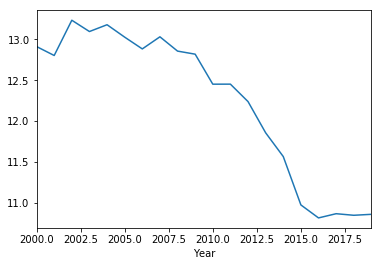

In [32]:
combined.groupby('Year')["Fuel Consumption Comb"].mean().plot()

And now I want to do all that again but using the French data files - maybe to compare that they're the same. Now that it's all set up, it's easy!

In [33]:
fr_consumption_files = download_files("AM[0-9]{4} Cotes de consommation de carburant.*csv")

Datasets provide model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada.

To help you compare vehicles from different model years, the fuel consumption ratings for 1995 to 2014 vehicles have been adjusted to reflect the improved testing that is more representative of everyday driving. Note that these are approximate values that were generated from the original ratings, not from vehicle testing.

For more information on fuel consumption testing, visit: https://www.nrcan.gc.ca/energy/efficiency/transportation/21008.

To compare the fuel consumption information of 1995 to 2019 model year vehicles, use the fuel consumption ratings search tool at https://fcr-ccc.nrcan-rncan.gc.ca/en.

(Data update: June 27, 2019)



In [34]:
combined_fr =load_and_clean_emissions_files(fr_consumption_files)

# All of the numbers match!
combined_fr.mean() == combined.mean()

Year                     True
Engine Size              True
Cylinders                True
Fuel Consumption City    True
Fuel Consumption Hwy     True
Fuel Consumption Comb    True
Comb (mpg)               True
CO2 Emissions            True
CO2 Rating               True
Smog Rating              True
dtype: bool

## There's often more than one way to do it
Another way to deal with a two line header, or other scenarios where there is extra data at the start of a file, is to set the `names`, `skiprows`, and `header` options when reading in the file. Another similar option is `skipfooter` if you have a known number of footer lines to skip. However, with this dataset, we can't use the same code to handle both the varying numbers of columns and the extra junk columns easily on read.

In [35]:
# It will deal with too many columns just fine
newer_colnames = ['Year', 'Make', 'Model', 'Class', 'Engine Size',
        'Cylinders', 'Transmission', 'Fuel Type',
        'Fuel Consumption City', 'Fuel Consumption Hwy', 'Fuel Consumption Comb',
        'Comb (mpg)', 'CO2 Emissions', 'CO2 Rating', 'Smog Rating']
pd.read_csv('downloads/MY2000 Fuel Consumption Ratings 5-cycle.csv', names=newer_colnames, skiprows=3, header=None).head()

,Year,Make,Model,Class,Engine Size,Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,Comb (mpg),CO2 Emissions,CO2 Rating,Smog Rating
0,2000,ACURA,1.6EL,COMPACT,1.6,4.0,A4,X,10.5,8.0,9.4,30.0,216.0,NaN,NaN
1,2000,ACURA,1.6EL,COMPACT,1.6,4.0,M5,X,9.8,7.8,8.9,32.0,205.0,NaN,NaN
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6.0,AS5,Z,13.7,8.8,11.5,25.0,265.0,NaN,NaN
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6.0,A4,Z,15.0,10.9,13.1,22.0,301.0,NaN,NaN
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4.0,A4,X,11.4,8.3,10.0,28.0,230.0,NaN,NaN


In [36]:
# But because of the extra blank columns in some of the files I also have to set usecols
# but this throws an error if I use it on the older files
pd.read_csv('downloads/MY2019 Fuel Consumption Ratings.csv',
            names=newer_colnames,
            usecols=range(0, len(newer_colnames)),
            skiprows=3,
            header=None).head()

,Year,Make,Model,Class,Engine Size,Cylinders,Transmission,Fuel Type,Fuel Consumption City,Fuel Consumption Hwy,Fuel Consumption Comb,Comb (mpg),CO2 Emissions,CO2 Rating,Smog Rating
0,2019,Acura,ILX,Compact,2.4,4.0,AM8,Z,9.9,7.0,8.6,33.0,199.0,6.0,3.0
1,2019,Acura,MDX SH-AWD,SUV: Small,3.5,6.0,AS9,Z,12.2,9.0,10.8,26.0,252.0,4.0,3.0
2,2019,Acura,MDX SH-AWD A-SPEC,SUV: Small,3.5,6.0,AS9,Z,12.2,9.5,11.0,26.0,258.0,4.0,3.0
3,2019,Acura,MDX Hybrid AWD,SUV: Small,3.0,6.0,AM7,Z,9.1,9.0,9.0,31.0,210.0,5.0,3.0
4,2019,Acura,NSX,Two-seater,3.5,6.0,AM9,Z,11.1,10.8,11.0,26.0,261.0,4.0,3.0


If our problem with column names was just that they were spread out over two rows, we could write some code to automatically merge them.

In [37]:
# Update column names
def merge_2_row_names(data):
    new_columns = []
    for i, c in enumerate(data.columns):
        new_name = ""
        first_row_val = data.iloc[0, i]
        
        if c.startswith("Unnamed"):
            new_name = first_row_val
        elif not isinstance(first_row_val, str):
            new_name = c
        else:
            new_name = c + " " + first_row_val
        new_columns.append(new_name)
    data.columns = new_columns
    
    return data.drop(0)


merge_2_row_names(pd.read_csv('downloads/MY2000 Fuel Consumption Ratings 5-cycle.csv'))

,MODEL YEAR,MAKE,MODEL.1 # = high output engine,VEHICLE CLASS,ENGINE SIZE (L),CYLINDERS,TRANSMISSION,FUEL TYPE,FUEL CONSUMPTION* CITY (L/100 km),HWY (L/100 km),COMB (L/100 km),COMB (mpg),CO2 EMISSIONS (g/km)
1,2000,ACURA,1.6EL,COMPACT,1.6,4.0,A4,X,10.5,8,9.4,30,216
2,2000,ACURA,1.6EL,COMPACT,1.6,4.0,M5,X,9.8,7.8,8.9,32,205
3,2000,ACURA,3.2TL,MID-SIZE,3.2,6.0,AS5,Z,13.7,8.8,11.5,25,265
4,2000,ACURA,3.5RL,MID-SIZE,3.5,6.0,A4,Z,15,10.9,13.1,22,301
5,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4.0,A4,X,11.4,8.3,10,28,230
6,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4.0,M5,X,10.6,8.1,9.5,30,219
7,2000,ACURA,INTEGRA GSR/TYPE R,SUBCOMPACT,1.8,4.0,M5,Z,10.8,8.3,9.7,29,223
8,2000,ACURA,NSX,SUBCOMPACT,3,6.0,AS4,Z,15.2,10.9,13.3,21,306
9,2000,ACURA,NSX,SUBCOMPACT,3.2,6.0,M6,Z,15.4,10.7,13.3,21,306
10,2000,AUDI,A4,COMPACT,1.8,4.0,A5,Z,12.9,8.6,10.9,26,251
